In [52]:
import warnings
warnings.filterwarnings("ignore")

# 3. Simple forecasting pipelines in `sktime`

Until now: How can we use sktime to create forecasts.


Now: How can we improve the forecasts.

* endogenous transformation pipelines via `TransformedTargetForecaster`
* exogenous transformation pipelines via `ForecastingPipeline`
* feature extraction compositors
    * `FeatureUnion` and `ColumnSelect` for multiple feature extraction
    * `ColumnEnsembleForecaster` and `ColumnEnsembleTransformer` to apply per variable
* forecasting exogenous variables via `ForecastX`

## 3.1 Introducing transformers for forecasting pipelines

or: why transformer estimators are the "right" concept to modularize forecasting pipelines

suppose we want to forecast this well-known dataset
(airline passengers by year in a fixed scope)

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

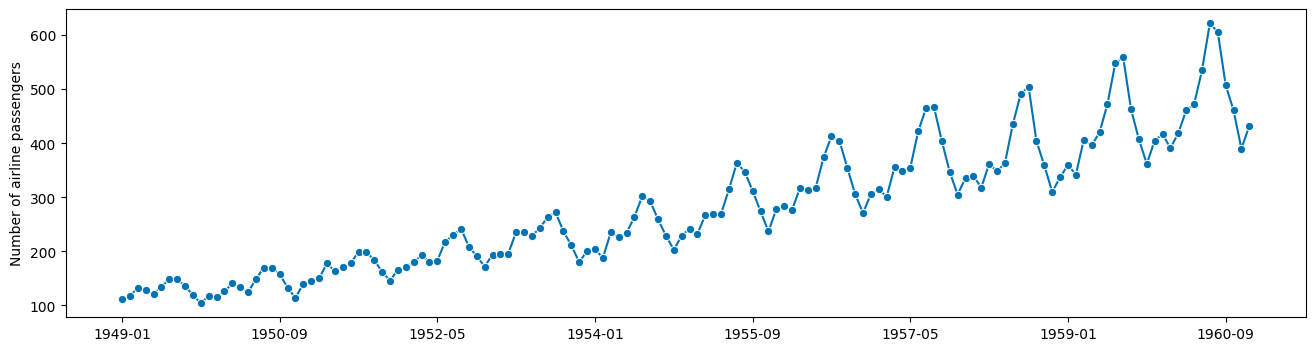

In [53]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

y = load_airline()
plot_series(y)

observations:

* there is seasonal periodicity, 12 month period
* seasonal periodicity looks multiplicative (not additive) to trend

idea: forecast might be easier

* with seasonality removed
* on logarithmic value scale (multiplication becomes addition)

### 3.1.1 Manual tranformations: doing things the wrong way

Maybe doing this manually step by step is a good idea?

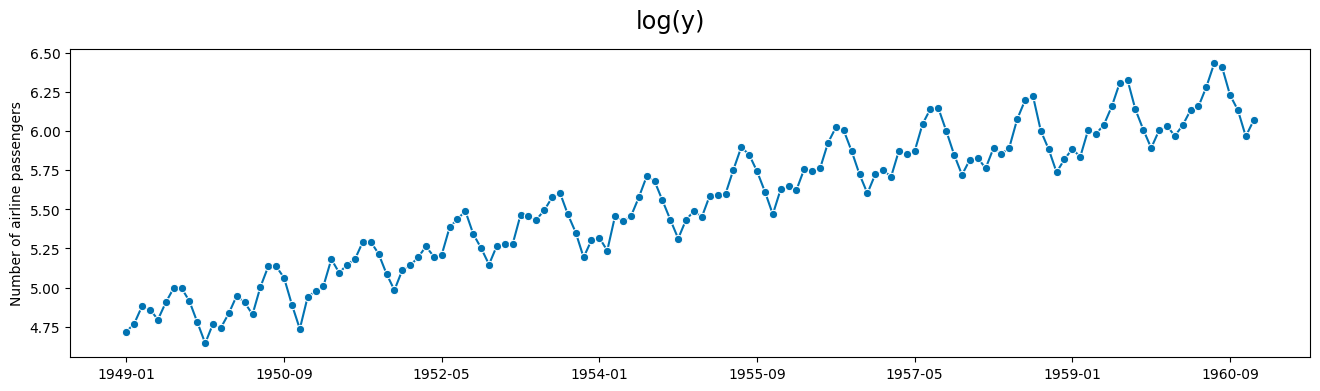

In [54]:
import numpy as np

y_log = np.log(y)

fig, ax = plot_series(y_log, title="log(y)")

this looks additive now!

ok, what next - deaseasonalization

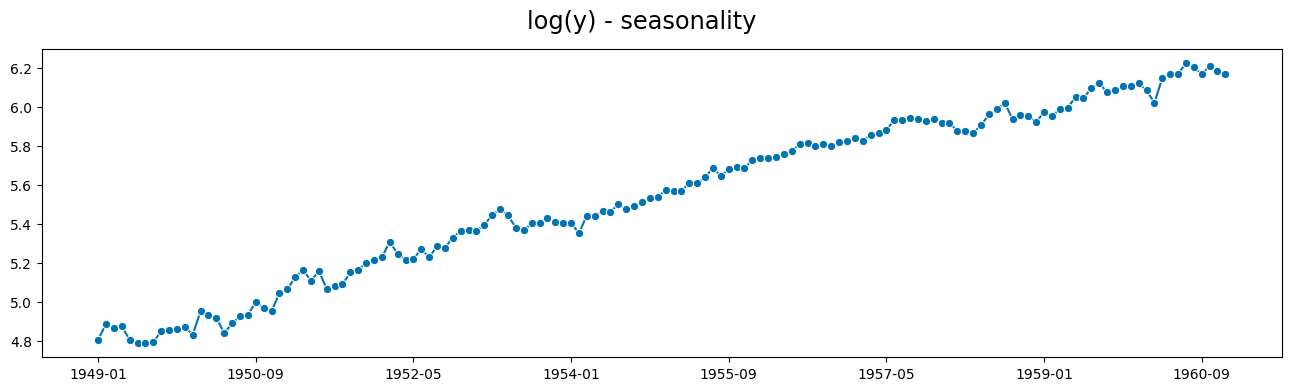

In [55]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_result = seasonal_decompose(y_log, period=12)
seasonal = seasonal_result.seasonal
y_log_deseasonalised = y_log - seasonal

fig, ax = plot_series(y_log_deseasonalised, title="log(y) - seasonality")

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='trend'>)

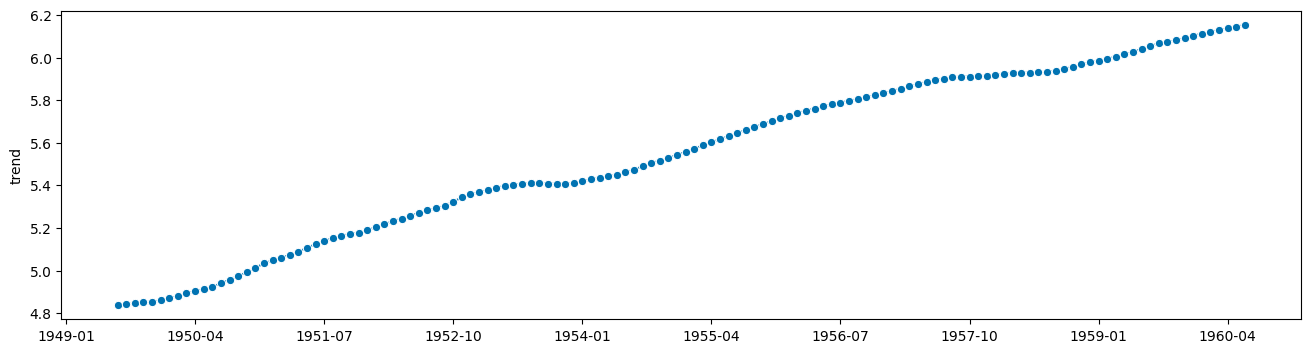

In [56]:
trend = seasonal_result.trend
plot_series(trend)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='seasonal'>)

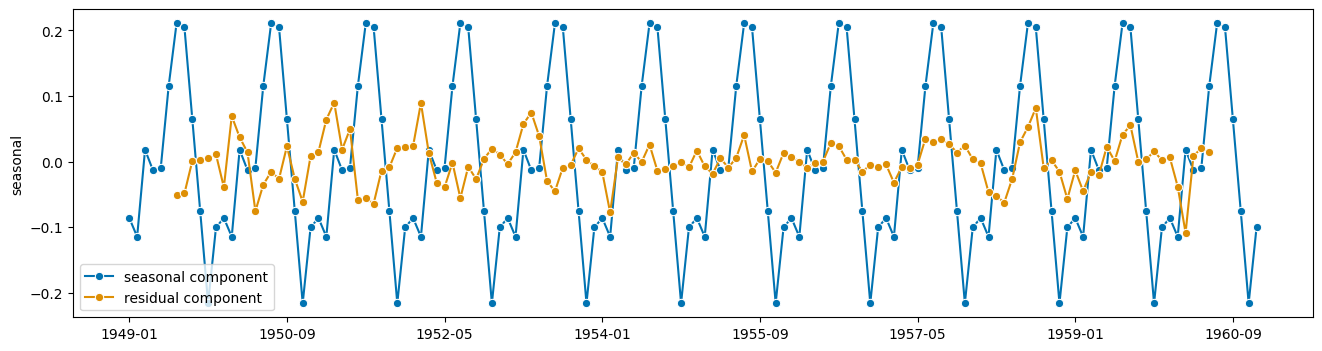

In [57]:
resid = seasonal_result.resid
plot_series(seasonal, resid, labels=["seasonal component", "residual component"])

now:

* forecast on this
* add back seasonal component
* invert logarithm (exponentiate)

start with forecast...

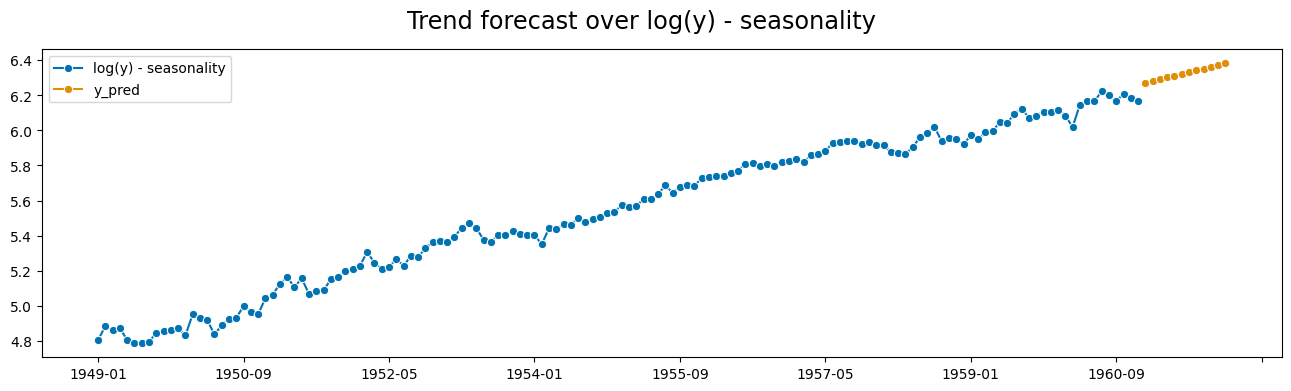

In [58]:
from sktime.forecasting.trend import TrendForecaster

forecaster = TrendForecaster()

fh = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] # Alternatively: list(range(1, 13))
y_pred = forecaster.fit_predict(y_log_deseasonalised, fh=fh)

fig, ax = plot_series(
    y_log_deseasonalised,
    y_pred,
    labels=["log(y) - seasonality", "y_pred"],
    title="Trend forecast over log(y) - seasonality",
)

looks reasonable!

Now to turn this into a forecast of the original y ...

* add seasonal
* invert the logarithm

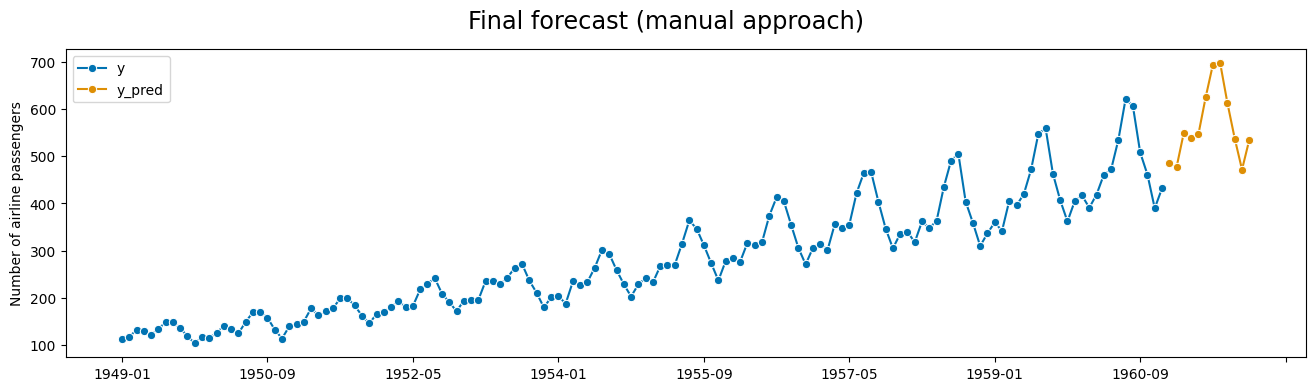

In [59]:
y_pred_add_seasonality = y_pred + seasonal[0:12].values
y_pred_orig = np.exp(y_pred_add_seasonality)

fig, ax = plot_series(y, y_pred_orig, labels=["y", "y_pred"], title="Final forecast (manual approach)")

ok, done! and it only took us 10 years.

Maybe there is a better way?

### 3.1.2 `sktime` transformers: doing things the right way


Solution: use transformers & pipelines!

Same interface at every step! Easily composable!


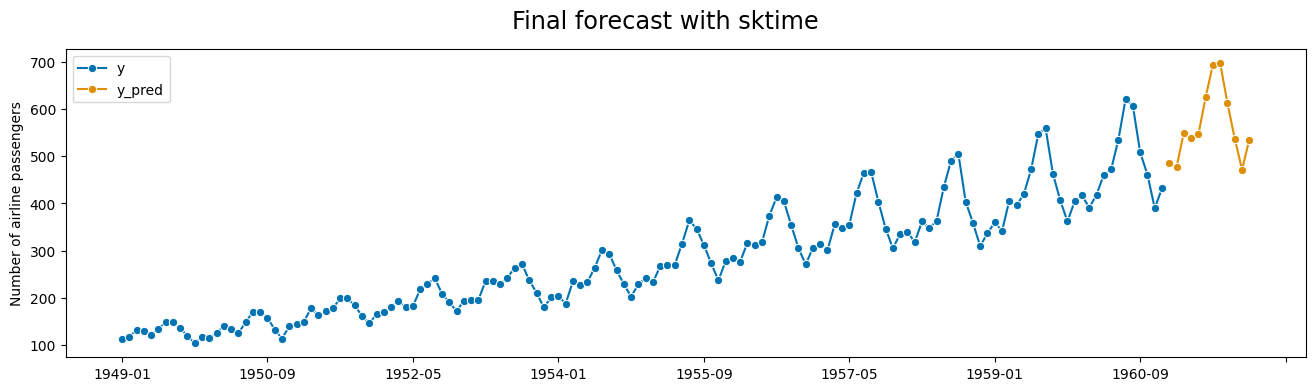

In [60]:
from sktime.forecasting.trend import TrendForecaster
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer

y = load_airline()

forecaster = LogTransformer() * Deseasonalizer(sp=12) * TrendForecaster()

fh = list(range(1, 13))
y_pred = forecaster.fit_predict(y, fh=fh)

fig, ax = plot_series(y, y_pred, labels=["y", "y_pred"], title="Final forecast with sktime")

what happened here?

The "chain" operator `*` creates a "forecasting pipeline"

Has the same interface as all other forecasters! No additional data fiddling!

Transformers "slot in" as standardized components.

In [61]:
forecaster

TransformedTargetForecaster(steps=[LogTransformer(), Deseasonalizer(sp=12),
                                   TrendForecaster()])

Let's look at this in more detail:

* `sktime` transformers interface
* `sktime` pipeline building

## 3.2 Transformers - More Detailed

* transformer interface
* transformer types
* searching transformers by type
* broadcasting/vectorization to panel & hierarchical data
* transformers and pipelines

### 3.2.1 What are transformers? <a class="anchor" id="section_1_1"></a>

Transformer = modular data processing steps commonly used in machine learning

("transformer" used in the sense of `scikit-learn`)

Transformers are estimators that:

* are fitted to a batch of data via `fit(data)`, changing its state
* are applied to another batch of data via `transform(X)`, producing transformed data
* may have an `inverse_transform(X)`

In `sktime`, input `X` to `fit` and `transform` is typically a time series or a panel (collection of time series).

Basic use of an `sktime` time series transformer is as follows:

In [62]:
# 1. prepare the data
from sktime.utils._testing.series import _make_series

X = _make_series()
X_train = X[:7]
X_test = X[7:12]
# X_train and X_test are both pandas.Series

X_train, X_test

(2000-01-01    3.768237
 2000-01-02    3.669548
 2000-01-03    3.882731
 2000-01-04    4.154350
 2000-01-05    3.843151
 2000-01-06    3.912789
 2000-01-07    4.233510
 Freq: D, dtype: float64,
 2000-01-08    3.595643
 2000-01-09    4.237620
 2000-01-10    4.420467
 2000-01-11    3.642849
 2000-01-12    4.105305
 Freq: D, dtype: float64)

In [63]:
# 2. construct the transformer
from sktime.transformations.series.boxcox import BoxCoxTransformer

# trafo is an sktime estimator inheriting from BaseTransformer
# Box-Cox transform with lambda parameter fitted via mle
trafo = BoxCoxTransformer(method="mle")

In [64]:
# 3. fit the transformer to training data
trafo.fit(X_train)

# 4. apply the transformer to transform test data
# Box-Cox transform with lambda fitted on X_train
X_transformed = trafo.transform(X_test)

X_transformed

2000-01-08    0.190021
2000-01-09    0.190153
2000-01-10    0.190172
2000-01-11    0.190036
2000-01-12    0.190135
Freq: D, dtype: float64

If the training and test set is the same, step 3 and 4 can be carried out more concisely (and sometimes more efficiently) by using `fit_transform`:

In [65]:
# 3+4. apply the transformer to fit and transform on the same data, X
X_transformed = trafo.fit_transform(X)

 For time series transformers, the metadata tags describe the expected output of `transform`:

In [66]:
trafo.get_tag("scitype:transform-input")

'Series'

In [67]:
trafo.get_tag("scitype:transform-output")

'Series'

To find transformers, use `all_estimators` and filter by tags:

* `"scitype:transform-output"` - the output scitype. `Series` for time series, `Primitives` for primitive features (float, categories), `Panel` for collections of time series.
* `"scitype:transform-input"` - the input scitype. `Series` for time series.
* `"scitype:instancewise"` - If `True`, vectorized operation per series. If `False`, uses multiple time series non-trivially.

Example: find all transformers that transform time series to time series

In [68]:
from sktime.registry import all_estimators

# now subset to transformers that extract scalar features
all_estimators(
    "transformer",
    as_dataframe=True,
    filter_tags={"scitype:transform-output": "Series"},
    suppress_import_stdout=False,
)

,name,object
0,Aggregator,<class 'sktime.transformations.hierarchical.ag...
1,AutoCorrelationTransformer,<class 'sktime.transformations.series.acf.Auto...
2,BKFilter,<class 'sktime.transformations.series.bkfilter...
3,BoxCoxTransformer,<class 'sktime.transformations.series.boxcox.B...
4,CFFilter,<class 'sktime.transformations.series.cffilter...
...,...,...
83,TransformerPipeline,<class 'sktime.transformations.compose._pipeli...
84,TruncationTransformer,<class 'sktime.transformations.panel.truncatio...
85,WhiteNoiseAugmenter,<class 'sktime.transformations.series.augmente...
86,WindowSummarizer,<class 'sktime.transformations.series.summariz...


A more complete overview on transformer types and tags is given in the `sktime` transformers tutorial.


### 3.2.3 Hierarchical Transformers

* Either transformers are natively multivariate or
* If not: Broadcasting aka vectorization of transformers

This ensures that all `sktime` transformers can be applied to multivariate and multi-instance (panel, hierarchical) time series data.

Example: broadcasting/vectorization of time series to time series transformer

The `BoxCoxTransformer` from previous sections applies to single instances of univariate time series. When multiple instances or variables are seen, it broadcasts across both:

In [69]:
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.utils._testing.hierarchical import _make_hierarchical

# hierarchical data with 2 variables and 2 levels
X = _make_hierarchical(n_columns=2)

X

c0        c1
h0   h1   time                          
h0_0 h1_0 2000-01-01  5.158035  4.824313
          2000-01-02  3.367790  4.195304
          2000-01-03  4.840640  3.113695
          2000-01-04  2.094782  4.655306
          2000-01-05  4.335904  5.682408
...                        ...       ...
h0_1 h1_3 2000-01-08  4.679849  4.702915
          2000-01-09  5.545101  3.532483
          2000-01-10  3.901046  1.000000
          2000-01-11  3.648236  5.238878
          2000-01-12  2.718654  5.297932

[96 rows x 2 columns]

In [70]:
# constructing the transformers
boxcox_trafo = BoxCoxTransformer(method="mle")

# applying to X results in hierarchical data
boxcox_trafo.fit_transform(X)

c0         c1
h0   h1   time                           
h0_0 h1_0 2000-01-01  4.705367   5.408161
          2000-01-02  2.582237   4.356699
          2000-01-03  4.321509   2.674940
          2000-01-04  1.150140   5.120761
          2000-01-05  3.717260   6.919141
...                        ...        ...
h0_1 h1_3 2000-01-08  2.904412  12.293148
          2000-01-09  3.478407   6.459496
          2000-01-10  2.364424   0.000000
          2000-01-11  2.183460  15.599302
          2000-01-12  1.488159  15.988394

[96 rows x 2 columns]

Fitted model components of vectorized transformers can be found in the `transformers_` attribute, or accessed via the universal `get_fitted_params` interface:

In [71]:
boxcox_trafo.transformers_
# this is a pandas.DataFrame that contains the fitted transformers
# one per time series instance and variable

c0                   c1
h0_0 h1_0  BoxCoxTransformer()  BoxCoxTransformer()
     h1_1  BoxCoxTransformer()  BoxCoxTransformer()
     h1_2  BoxCoxTransformer()  BoxCoxTransformer()
     h1_3  BoxCoxTransformer()  BoxCoxTransformer()
h0_1 h1_0  BoxCoxTransformer()  BoxCoxTransformer()
     h1_1  BoxCoxTransformer()  BoxCoxTransformer()
     h1_2  BoxCoxTransformer()  BoxCoxTransformer()
     h1_3  BoxCoxTransformer()  BoxCoxTransformer()

In [72]:
boxcox_trafo.get_fitted_params()
# this returns a dictionary
# the transformers DataFrame is available at the key "transformers"
# individual transformers are available at dataframe-like keys
# it also contains all fitted lambdas as keyed parameters

{'transformers':                             c0                   c1
 h0_0 h1_0  BoxCoxTransformer()  BoxCoxTransformer()
      h1_1  BoxCoxTransformer()  BoxCoxTransformer()
      h1_2  BoxCoxTransformer()  BoxCoxTransformer()
      h1_3  BoxCoxTransformer()  BoxCoxTransformer()
 h0_1 h1_0  BoxCoxTransformer()  BoxCoxTransformer()
      h1_1  BoxCoxTransformer()  BoxCoxTransformer()
      h1_2  BoxCoxTransformer()  BoxCoxTransformer()
      h1_3  BoxCoxTransformer()  BoxCoxTransformer(),
 "transformers.loc[('h0_0', 'h1_0'),'c0']": BoxCoxTransformer(),
 "transformers.loc[('h0_0', 'h1_0'),'c0']__lambda": 1.1181515647485873,
 "transformers.loc[('h0_0', 'h1_0'),'c1']": BoxCoxTransformer(),
 "transformers.loc[('h0_0', 'h1_0'),'c1']__lambda": 1.3412263944457086,
 "transformers.loc[('h0_0', 'h1_1'),'c0']": BoxCoxTransformer(),
 "transformers.loc[('h0_0', 'h1_1'),'c0']__lambda": -1.180887047183,
 "transformers.loc[('h0_0', 'h1_1'),'c1']": BoxCoxTransformer(),
 "transformers.loc[('h0_0', 'h1_1

### 3.3 Sequential Pipelines, Feature Engineering

`sktime` transformers can be pipelined with any other `sktime` estimator type, including forecasters, classifiers, and other transformers.

Pipelines = estimators of the same type, same interface as specialized class

pipeline build operation: `make_pipeline` or via `*` dunder

Pipelining `pipe = trafo * est` produces `pipe` of same type as `est`.

In `pipe.fit`, first `trafo.fit_transform`, then `est.fit` is executed on the result.

In `pipe.predict`, first `trafo.transform`, then `est.predict` is executed.

(the arguments that are piped differ by type and can be looked up in the docstrings of pipeline classes, or specialized tutorials)


transformers are natural pipeline components

* data processing steps
* feature engineering steps
* post processing steps

they can be combined in a number of other ways:

* pipelining = sequential chaining
* feature union = parallel, addition of features
* feature subsetting = selecting columns
* inversion = switch transform and inverse
* multiplexing = switching between transformers
* passthrough = switch on/ off

### 3.3.1 Chaining transformers via `*`

(or `TransformedTargetForecaster`)

Let's re-examine the pipeline ethat we have seen

In [73]:
from sktime.forecasting.trend import TrendForecaster
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer

pipe = LogTransformer() * Deseasonalizer(sp=12) * TrendForecaster()
pipe

TransformedTargetForecaster(steps=[LogTransformer(), Deseasonalizer(sp=12),
                                   TrendForecaster()])

`*` applies transformers to the endogenous data as follows:

* in `fit`, does `fit_transform`, then passes on
* in `predict`, takes input, then does `inverse_transform`

`pipe` is a `TransformedTargetForecaster`, which we could also have specified as follows:

In [74]:
from sktime.forecasting.compose import TransformedTargetForecaster

pipe_explicit = TransformedTargetForecaster(
    [
        ("log", LogTransformer()),
        ("deseasonalise", Deseasonalizer(sp=12)),
        ("forecast", TrendForecaster()),
    ]
)
pipe_explicit

TransformedTargetForecaster(steps=[('log', LogTransformer()),
                                   ('deseasonalise', Deseasonalizer(sp=12)),
                                   ('forecast', TrendForecaster())])

`*` dunder automatically constructs the "right" pipeline, compare:

pipeline building is compatible with sklearn transformers!

default applies sklearn transformer per individual time series as a data frame table

In [75]:
from sklearn.preprocessing import StandardScaler

pipe_with_sklearn = Deseasonalizer(sp=12) * StandardScaler() * TrendForecaster()
pipe_with_sklearn

TransformedTargetForecaster(steps=[Deseasonalizer(sp=12),
                                   TabularToSeriesAdaptor(transformer=StandardScaler()),
                                   TrendForecaster()])

the `StandardScaler` is wrapped in `transformations.series.adapt.TabularToSeriesAdaptor`

composites are compatible with `get_params` / `set_params` parameter interface:

In [76]:
pipe.get_params()

{'steps': [LogTransformer(), Deseasonalizer(sp=12), TrendForecaster()],
 'LogTransformer': LogTransformer(),
 'Deseasonalizer': Deseasonalizer(sp=12),
 'TrendForecaster': TrendForecaster(),
 'LogTransformer__offset': 0,
 'LogTransformer__scale': 1,
 'Deseasonalizer__model': 'additive',
 'Deseasonalizer__sp': 12,
 'TrendForecaster__regressor': None}

### 3.3.2 Transforming exogenous data via `**`

or `ForecastingPipeline`

`**` applies transformers to the exogenous data, `X`:

* in `fit`, applies `fit_transform` to `X` and passes it on
* in `predict`, applies `transform` to `X` and passes it on

In [77]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.transformations.series.impute import Imputer

from sklearn.preprocessing import MinMaxScaler

forecaster = NaiveForecaster(strategy="drift")
imputer = Imputer(method="mean")

pipe = imputer ** MinMaxScaler() ** forecaster
pipe

ForecastingPipeline(steps=[Imputer(method='mean'),
                           TabularToSeriesAdaptor(transformer=MinMaxScaler()),
                           NaiveForecaster(strategy='drift')])

we can also bracket - then, important, use `*` for transformer composition:

In [78]:
pipe = (imputer * MinMaxScaler()) ** forecaster

"verbose" definition for configurability of names:

In [79]:
from sktime.forecasting.compose import ForecastingPipeline
from sktime.transformations.series.adapt import TabularToSeriesAdaptor

pipe_explicit = ForecastingPipeline(
    steps=[
        ("imputer", Imputer(method="mean")),
        ("minmaxscaler", TabularToSeriesAdaptor(MinMaxScaler())),
        ("forecaster", NaiveForecaster(strategy="drift")),
    ]
)

we can use both `*` and `**` to apply transformers to endogenous and exogenous data:

In [80]:
pipe_endo = LogTransformer() * Deseasonalizer(sp=12) * TrendForecaster()
pipe = (Imputer(method="mean") * MinMaxScaler()) ** pipe_endo

### 3.3.3 Feature union via `+`

let's say we waqnt to extract features:

* first differences of time series
* first lag of time series

of the exogenous variables

In [81]:
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.lag import Lag

pipe = Differencer() + Lag(1)

# this constructs a FeatureUnion, which is also a transformer
pipe

FeatureUnion(transformer_list=[Differencer(), Lag(lags=1)])

In [82]:
from sktime.utils._testing.hierarchical import _bottom_hier_datagen

X = _bottom_hier_datagen(no_levels=1, no_bottom_nodes=2)

# applies both Differencer and Lag, returns transformed in different columns
pipe.fit_transform(X)

Differencer__passengers  Lag__lag_1__passengers
l1_agg    timepoints                                                 
l1_node01 1949-01                    0.000000                     NaN
          1949-02                    6.000000              112.000000
          1949-03                   14.000000              118.000000
          1949-04                   -3.000000              132.000000
          1949-05                   -8.000000              129.000000
...                                       ...                     ...
l1_node02 1960-10                 -207.308925             1921.614311
          1960-11                 -304.302413             1714.305386
          1960-12                  178.684110             1410.002973
l1_node01 1961-01                         NaN              432.000000
l1_node02 1961-01                         NaN             1588.687083

[290 rows x 2 columns]

to retain the original columns, use the `Id` transformer:

In [83]:
from sktime.transformations.compose import Id
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.lag import Lag

pipe = Id() + Differencer() + Lag([1, 2], index_out="original")

pipe.fit_transform(X)

Id__passengers  Differencer__passengers  \
l1_agg    timepoints                                            
l1_node01 1949-01         112.000000                 0.000000   
          1949-02         118.000000                 6.000000   
          1949-03         132.000000                14.000000   
          1949-04         129.000000                -3.000000   
          1949-05         121.000000                -8.000000   
...                              ...                      ...   
l1_node02 1960-08        2367.846565               -74.561541   
          1960-09        1921.614311              -446.232254   
          1960-10        1714.305386              -207.308925   
          1960-11        1410.002973              -304.302413   
          1960-12        1588.687083               178.684110   

                      Lag__lag_1__passengers  Lag__lag_2__passengers  
l1_agg    timepoints                                                  
l1_node01 1949-01                        NaN                     NaN  
          1949-02                 112.000000                     NaN  
          1949-03                 118.000000              112.000000  
          1949-04                 132.000000              118.000000  
          1949-05                 129.000000              132.000000  
...                                      ...                     ...  
l1_node02 1960-08                2442.408106             2042.715151  
          1960-09                2367.846565             2442.408106  
          1960-10                1921.614311             2367.846565  
          1960-11                1714.305386             1921.614311  
          1960-12                1410.002973             1714.305386  

[288 rows x 4 columns]

to add further features extact e.g. from timestamps 

In [84]:
from sktime.transformations.compose import Id
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.lag import Lag
from sktime.transformations.series.date import DateTimeFeatures

pipe = Id() + Differencer() + Lag([1, 2], index_out="original") + DateTimeFeatures(manual_selection=["month_of_year"])

pipe.fit_transform(X)

Id__passengers  Differencer__passengers  \
l1_agg    timepoints                                            
l1_node01 1949-01         112.000000                 0.000000   
          1949-02         118.000000                 6.000000   
          1949-03         132.000000                14.000000   
          1949-04         129.000000                -3.000000   
          1949-05         121.000000                -8.000000   
...                              ...                      ...   
l1_node02 1960-08        2367.846565               -74.561541   
          1960-09        1921.614311              -446.232254   
          1960-10        1714.305386              -207.308925   
          1960-11        1410.002973              -304.302413   
          1960-12        1588.687083               178.684110   

                      Lag__lag_1__passengers  Lag__lag_2__passengers  \
l1_agg    timepoints                                                   
l1_node01 1949-01                        NaN                     NaN   
          1949-02                 112.000000                     NaN   
          1949-03                 118.000000              112.000000   
          1949-04                 132.000000              118.000000   
          1949-05                 129.000000              132.000000   
...                                      ...                     ...   
l1_node02 1960-08                2442.408106             2042.715151   
          1960-09                2367.846565             2442.408106   
          1960-10                1921.614311             2367.846565   
          1960-11                1714.305386             1921.614311   
          1960-12                1410.002973             1714.305386   

                      DateTimeFeatures__month_of_year  
l1_agg    timepoints                                   
l1_node01 1949-01                                   1  
          1949-02                                   2  
          1949-03                                   3  
          1949-04                                   4  
          1949-05                                   5  
...                                               ...  
l1_node02 1960-08                                   8  
          1960-09                                   9  
          1960-10                                  10  
          1960-11                                  11  
          1960-12                                  12  

[288 rows x 5 columns]

In [85]:
# parameter inspection
pipe.get_params()

{'flatten_transform_index': True,
 'n_jobs': None,
 'transformer_list': [Id(),
  Differencer(),
  Lag(index_out='original', lags=[1, 2]),
  DateTimeFeatures(manual_selection=['month_of_year'])],
 'transformer_weights': None,
 'Id': Id(),
 'Differencer': Differencer(),
 'Lag': Lag(index_out='original', lags=[1, 2]),
 'DateTimeFeatures': DateTimeFeatures(manual_selection=['month_of_year']),
 'Differencer__lags': 1,
 'Differencer__memory': 'all',
 'Differencer__na_handling': 'fill_zero',
 'Lag__flatten_transform_index': True,
 'Lag__freq': None,
 'Lag__index_out': 'original',
 'Lag__keep_column_names': False,
 'Lag__lags': [1, 2],
 'Lag__remember_data': True,
 'DateTimeFeatures__feature_scope': 'minimal',
 'DateTimeFeatures__keep_original_columns': False,
 'DateTimeFeatures__manual_selection': ['month_of_year'],
 'DateTimeFeatures__ts_freq': None}

### 3.3.4 Subset input columns via `[colname]`

let's say we want to apply `Differencer` to column 0, and `Lag` to column 1

also we keep the original columns for illustration

In [86]:
from sktime.utils._testing.hierarchical import _make_hierarchical

X = _make_hierarchical(
    hierarchy_levels=(2, 2), n_columns=2, min_timepoints=3, max_timepoints=3
)

X

c0        c1
h0   h1   time                          
h0_0 h1_0 2000-01-01  2.081447  1.777396
          2000-01-02  1.792539  1.513146
          2000-01-03  3.147716  2.099986
     h1_1 2000-01-01  3.107849  2.380399
          2000-01-02  2.940331  1.087207
          2000-01-03  1.668675  3.241987
h0_1 h1_0 2000-01-01  2.956882  3.689778
          2000-01-02  2.919314  1.000000
          2000-01-03  2.482888  1.303352
     h1_1 2000-01-01  1.000000  1.341492
          2000-01-02  3.398420  1.768468
          2000-01-03  1.276870  2.759286

In [87]:
from sktime.transformations.compose import Id
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.lag import Lag

pipe = Id() + Differencer()["c0"] + Lag([1, 2], index_out="original")["c1"]

pipe.fit_transform(X)

Id__c0    Id__c1  TransformerPipeline_1__c0  \
h0   h1   time                                                        
h0_0 h1_0 2000-01-01  2.081447  1.777396                   0.000000   
          2000-01-02  1.792539  1.513146                  -0.288908   
          2000-01-03  3.147716  2.099986                   1.355177   
     h1_1 2000-01-01  3.107849  2.380399                   0.000000   
          2000-01-02  2.940331  1.087207                  -0.167518   
          2000-01-03  1.668675  3.241987                  -1.271656   
h0_1 h1_0 2000-01-01  2.956882  3.689778                   0.000000   
          2000-01-02  2.919314  1.000000                  -0.037568   
          2000-01-03  2.482888  1.303352                  -0.436426   
     h1_1 2000-01-01  1.000000  1.341492                   0.000000   
          2000-01-02  3.398420  1.768468                   2.398420   
          2000-01-03  1.276870  2.759286                  -2.121550   

                      TransformerPipeline_2__lag_1__c1  \
h0   h1   time                                           
h0_0 h1_0 2000-01-01                               NaN   
          2000-01-02                          1.777396   
          2000-01-03                          1.513146   
     h1_1 2000-01-01                               NaN   
          2000-01-02                          2.380399   
          2000-01-03                          1.087207   
h0_1 h1_0 2000-01-01                               NaN   
          2000-01-02                          3.689778   
          2000-01-03                          1.000000   
     h1_1 2000-01-01                               NaN   
          2000-01-02                          1.341492   
          2000-01-03                          1.768468   

                      TransformerPipeline_2__lag_2__c1  
h0   h1   time                                          
h0_0 h1_0 2000-01-01                               NaN  
          2000-01-02                               NaN  
          2000-01-03                          1.777396  
     h1_1 2000-01-01                               NaN  
          2000-01-02                               NaN  
          2000-01-03                          2.380399  
h0_1 h1_0 2000-01-01                               NaN  
          2000-01-02                               NaN  
          2000-01-03                          3.689778  
     h1_1 2000-01-01                               NaN  
          2000-01-02                               NaN  
          2000-01-03                          1.341492

auto-generated names can be replaced by using `FeatureUnion` explicitly:

In [88]:
from sktime.transformations.compose import FeatureUnion

pipe = FeatureUnion(
    [
        ("original", Id()),
        ("diff", Differencer()["c0"]),
        ("lag", Lag([1, 2], index_out="original")["c1"]),
    ]
)

pipe.fit_transform(X)

original__c0  original__c1  diff__c0  lag__lag_1__c1  \
h0   h1   time                                                               
h0_0 h1_0 2000-01-01      2.081447      1.777396  0.000000             NaN   
          2000-01-02      1.792539      1.513146 -0.288908        1.777396   
          2000-01-03      3.147716      2.099986  1.355177        1.513146   
     h1_1 2000-01-01      3.107849      2.380399  0.000000             NaN   
          2000-01-02      2.940331      1.087207 -0.167518        2.380399   
          2000-01-03      1.668675      3.241987 -1.271656        1.087207   
h0_1 h1_0 2000-01-01      2.956882      3.689778  0.000000             NaN   
          2000-01-02      2.919314      1.000000 -0.037568        3.689778   
          2000-01-03      2.482888      1.303352 -0.436426        1.000000   
     h1_1 2000-01-01      1.000000      1.341492  0.000000             NaN   
          2000-01-02      3.398420      1.768468  2.398420        1.341492   
          2000-01-03      1.276870      2.759286 -2.121550        1.768468   

                      lag__lag_2__c1  
h0   h1   time                        
h0_0 h1_0 2000-01-01             NaN  
          2000-01-02             NaN  
          2000-01-03        1.777396  
     h1_1 2000-01-01             NaN  
          2000-01-02             NaN  
          2000-01-03        2.380399  
h0_1 h1_0 2000-01-01             NaN  
          2000-01-02             NaN  
          2000-01-03        3.689778  
     h1_1 2000-01-01             NaN  
          2000-01-02             NaN  
          2000-01-03        1.341492

see more later in part 3 on how to use this with tuning for full structural AutoML!

### 3.3.5 applying transformations and forecasters by column

via `ColumnEnsemleTransformer` and `ColumnEnsembleForecaster`

Transformer:

In [89]:
from sktime.transformations.compose import ColumnEnsembleTransformer
from sktime.transformations.series.detrend import Detrender
from sktime.transformations.series.difference import Differencer
from sktime.datasets import load_longley


y = load_longley()[1][["GNP", "UNEMP"]]

transformer = ColumnEnsembleTransformer([("difference", Differencer(), 1),
                                         ("trend", Detrender(), 0),
                                        ])

transformer.fit_transform(y)


,UNEMP,GNP
Period,,
1947,0.0,2428.838235
1948,-31.0,6787.401471
1949,1357.0,-15363.035294
1950,-331.0,-9596.472059
1951,-1252.0,14001.091176
1952,-167.0,11246.654412
1953,-62.0,8854.217647
1954,1708.0,-14197.219118
1955,-674.0,-618.655882


Forecaster: 

In [90]:
from sktime.forecasting.compose import ColumnEnsembleForecaster
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.datasets import load_longley

y = load_longley()[1][["GNP", "UNEMP"]]
forecasters = [
    ("trend", PolynomialTrendForecaster(), 0),
    ("naive", NaiveForecaster(), 1),
]
forecaster = ColumnEnsembleForecaster(forecasters=forecasters)
forecaster.fit(y, fh=[1, 2, 3])
y_pred = forecaster.predict()

y_pred

,GNP,UNEMP
1963,564315.150000,4007.0
1964,585093.586765,4007.0
1965,605872.023529,4007.0


### 3.3.6 Forecasting individual components after signal decomposition

With the above tools, we can build a pipeline which does the following:

* decompose endogenous signal `y`, e.g., into trend, period (plus noise component)
* forecast these components with different forecasters
* recompose component forecasts to overall forecast

works with any signal decomposition transformer!
E.g., `VmdTransformer`

In [91]:
from sktime.datasets import load_airline
from sktime.transformations.series.vmd import VmdTransformer

y = load_airline()

pipe = VmdTransformer(K=3) * PolynomialTrendForecaster(degree=2)
pipe.fit(y, fh=[1, 2, 3])
y_pred = pipe.predict()

ModuleNotFoundError: No module named 'sktime.transformations.series.vmd'

In [ ]:
VmdTransformer(K=3).fit_transform(y)

,0,1,2
0,128.654276,-2.020496,1.555735
1,128.972157,1.285346,-3.651307
2,129.476412,2.653988,2.238389
3,130.047192,-0.772731,1.394003
4,130.664079,-4.794725,-3.770804
...,...,...,...
139,473.465669,22.981826,-7.867931
140,472.503019,-8.069162,1.260475
141,470.575221,-23.887253,7.637835
142,468.583438,-10.433452,-11.262866


combine with `ColumnEnsembleForecaster` to choose different forecasters per component!

## 3.4 Forecaster Pipeline Components to control exogenous variables

pipeline elements for granular control around exogenous variables:

* forecasting exogenous variables - `ForecastX`
* creating exogenous variables from endogenous variables - `YtoX`
* predicting endogenous variables using exogenous variables - `YfromX`

### 3.4.1 Forecasting Exogenous Variables

Sometimes a forecaster uses exogenous features that are itself forecasts.

In [ ]:
from sktime.datasets import load_longley
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series

y, X = load_longley()
y_train, y_test, X_train, X_test = temporal_train_test_split(y=y, X=X, test_size=6)
fh = ForecastingHorizon(y_test.index, is_relative=False)

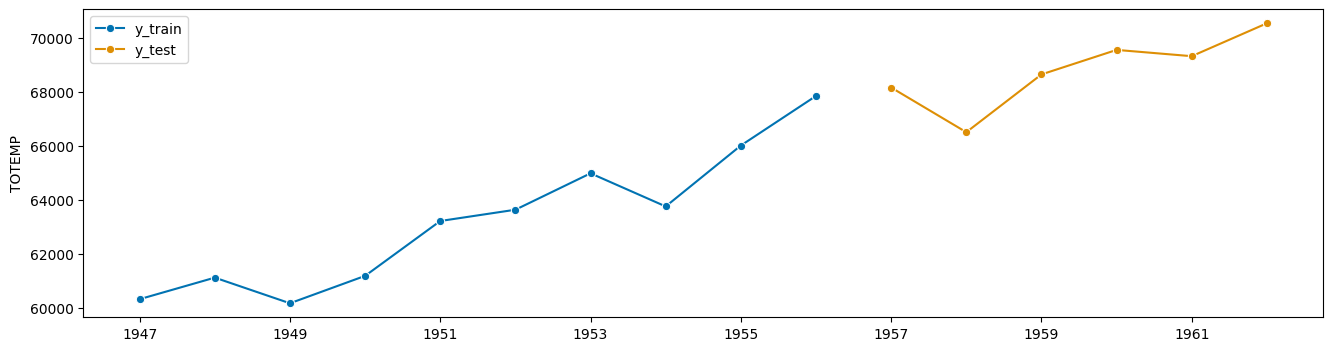

In [ ]:
plot_series(y_train, y_test, labels=["y_train", "y_test"]);


In [ ]:
X.head()


,GNPDEFL,GNP,UNEMP,ARMED,POP
Period,,,,,
1947,83.0,234289.0,2356.0,1590.0,107608.0
1948,88.5,259426.0,2325.0,1456.0,108632.0
1949,88.2,258054.0,3682.0,1616.0,109773.0
1950,89.5,284599.0,3351.0,1650.0,110929.0
1951,96.2,328975.0,2099.0,3099.0,112075.0


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='TOTEMP'>)

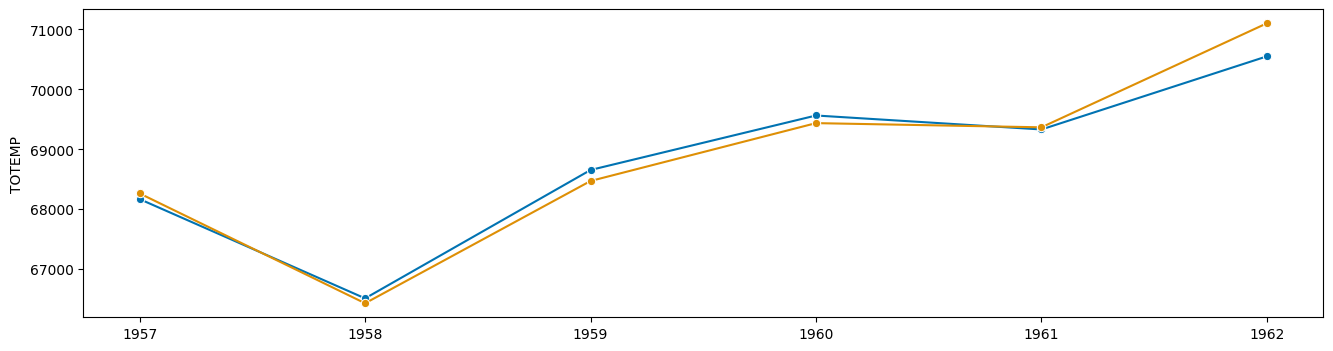

In [ ]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.compose import ForecastX
from sktime.forecasting.var import VAR

forecaster_X = ForecastX(
    forecaster_y=AutoARIMA(sp=1, suppress_warnings=True),
    forecaster_X=VAR(),
)
forecaster_X.fit(y=y, X=X, fh=fh)
# now in predict() we don't need to pass X
y_pred = forecaster_X.predict(fh=fh)

plot_series(y_test, y_pred)

### 3.4.2 Generating Exogenous Variables from Endogenous variables

use `YtoX` to generate custom exogenous variables derived from endogenous data.

Example: use lagged values of `y`:

In [ ]:
from sktime.datasets import load_longley
from sktime.forecasting.model_selection import temporal_train_test_split

y, X = load_longley()
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X)

In [ ]:
X_train.head()

,GNPDEFL,GNP,UNEMP,ARMED,POP
Period,,,,,
1947,83.0,234289.0,2356.0,1590.0,107608.0
1948,88.5,259426.0,2325.0,1456.0,108632.0
1949,88.2,258054.0,3682.0,1616.0,109773.0
1950,89.5,284599.0,3351.0,1650.0,110929.0
1951,96.2,328975.0,2099.0,3099.0,112075.0


In [ ]:
y_train.head()

Period
1947    60323.0
1948    61122.0
1949    60171.0
1950    61187.0
1951    63221.0
Freq: A-DEC, Name: TOTEMP, dtype: float64

for illustration, using the transformer by itself:

In [ ]:
from sktime.transformations.compose import YtoX
from sktime.transformations.series.lag import Lag

lagged_y_trafo = YtoX() * Lag(1)
lagged_y_trafo.fit(X_train, y_train)
lagged_y_trafo.transform(X_test, y_test)

,lag_1__TOTEMP
Period,
1959,66513.0
1960,68655.0
1961,69564.0
1962,69331.0
1963,70551.0


in a forecaster, the lagged values will be used as `X`:

In [ ]:
X_test

,GNPDEFL,GNP,UNEMP,ARMED,POP
Period,,,,,
1959,112.6,482704.0,3813.0,2552.0,123366.0
1960,114.2,502601.0,3931.0,2514.0,125368.0
1961,115.7,518173.0,4806.0,2572.0,127852.0
1962,116.9,554894.0,4007.0,2827.0,130081.0


In [ ]:
from sktime.forecasting.arima import ARIMA
from sktime.transformations.compose import YtoX
from sktime.transformations.series.impute import Imputer
from sktime.transformations.series.lag import Lag

lagged_y_trafo = YtoX() * Lag(1, index_out="original") * Imputer()
# we need to specify index_out="original" as otherwise ARIMA gets 1 and 2 ahead
forecaster = lagged_y_trafo ** ARIMA()  # this uses lagged_y_trafo to generate X

forecaster.fit(y_train, X=X_train, fh=[1])  # try to forecast next year - with 1 year lag value
forecaster.predict(X=X_test)  # dummy X to predict next year

TypeError: _transform output of <class 'sktime.transformations.compose._ytox.YtoX'> does not comply with sktime mtype specifications. See datatypes.MTYPE_REGISTER for mtype specifications. Returned error message: ["obj must be a pandas.DataFrame, found <class 'NoneType'>", "obj must be a pandas.Series, found <class 'NoneType'>", "obj must be a numpy.ndarray, found <class 'NoneType'>"]. Returned object: None

## 3.5 Parameter tuning and autoML

Lot of hyperparameters in a pipeline. How to optimise?

tuning = automated setting of parameters, e.g., seasonality

autoML = automated setting of model choice, model structure

We'll see three kinds:

* parameter estimation - setting parameters by specific procedure, e.g., seasonality estimation
* tuning, grid/random search - using backtesting to set any model parameter
* auto-ML - applying tuning to model choice or pipeline structure choice

### 3.5.1 Parameter estimation, e.g., seasonality, stationarity

In the airline data example, it was pretty evident that we had seasonality. 

But sometimes it isn't so clear cut... 

How do to estimate seasonality? How to automate seasonality estimation?

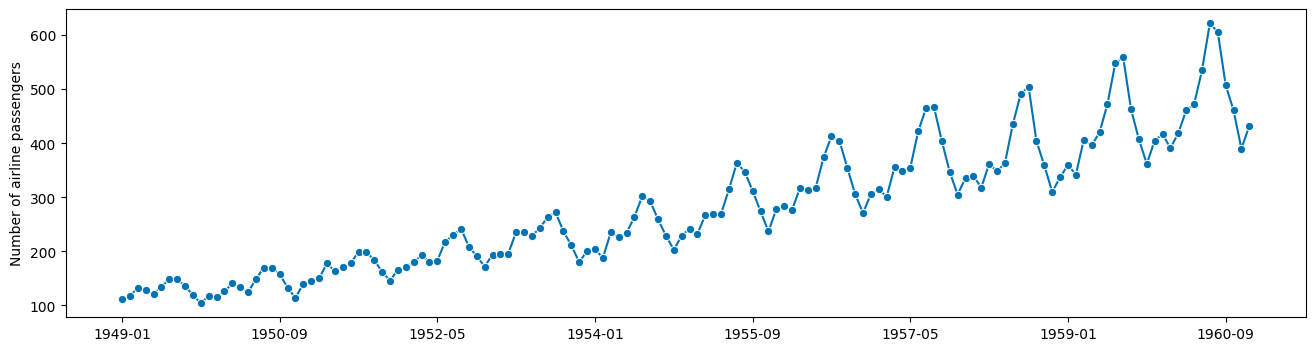

In [ ]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

y = load_airline()

fig, ax = plot_series(y)

The classical way uses autocorrelation plots.

Manual approach using `statsmodels` or `sktime` (thinly wrapping `statsmodels`):

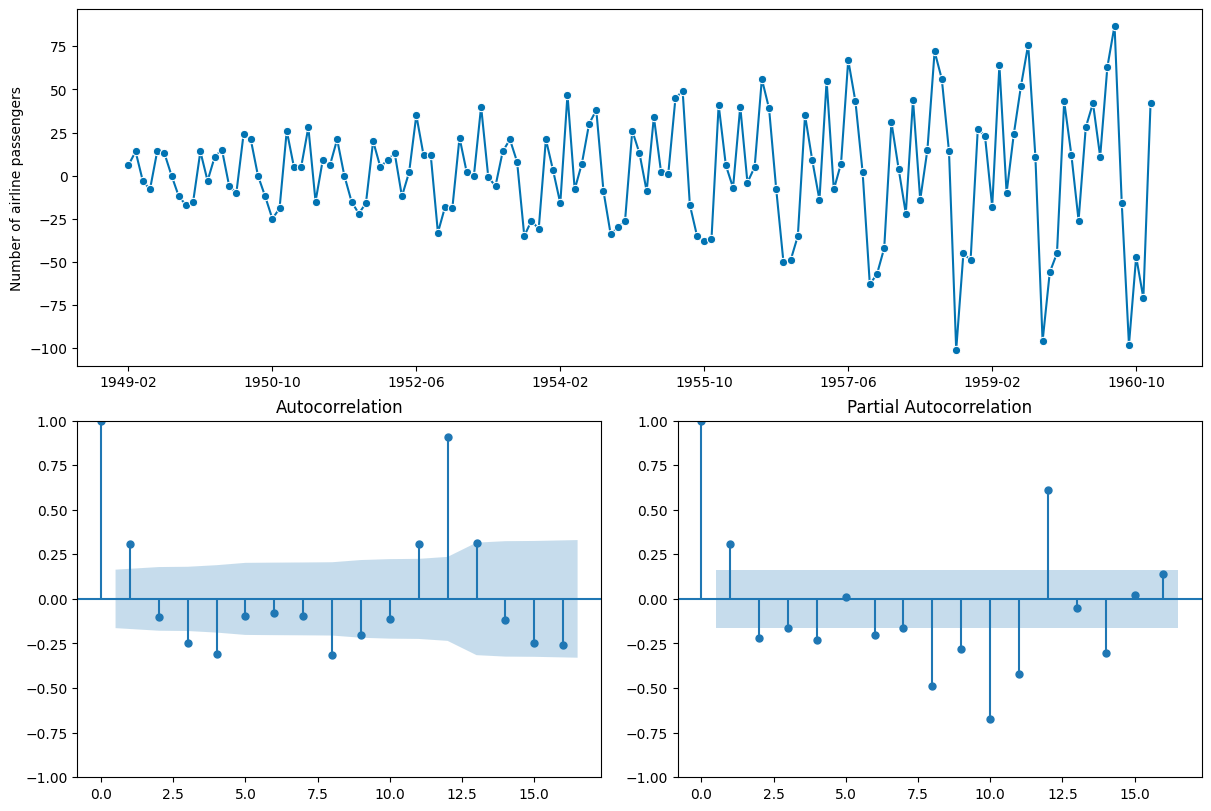

In [ ]:
from sktime.utils.plotting import plot_correlations

# acf/pacf on differences to ensure stationarity, there is a visible trend
fig, ax = plot_correlations(y.diff()[1:], lags=16)

`sktime` has a systematic interface for parameter estimators that allows auto-setting of seasonality:

the "parameter estimator" type:

In [ ]:
from sktime.param_est.seasonality import SeasonalityACF
from sktime.transformations.series.difference import Differencer

# compute seasonality on first differences
sp_est = Differencer() * SeasonalityACF()

sp_est.fit(y)

ParamFitterPipeline(param_est=SeasonalityACF(), transformers=[Differencer()])

In [ ]:
sp_est.get_fitted_params()["sp"]

12

In [ ]:
# more stats in here
list(sp_est.get_fitted_params().keys())

['acf',
 'confint',
 'sp',
 'sp_significant',
 'param_est__acf',
 'param_est__confint',
 'param_est__sp',
 'param_est__sp_significant',
 'transformers__steps',
 'transformers__Differencer']

using pipelining, we can plug in the fitted `sp` parameter into any estimator!

In [ ]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.param_est.plugin import PluginParamsForecaster

fcst = NaiveForecaster()
sp_auto = PluginParamsForecaster(sp_est, fcst)
sp_auto.fit(y, fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

PluginParamsForecaster(forecaster=NaiveForecaster(),
                       param_est=ParamFitterPipeline(param_est=SeasonalityACF(),
                                                     transformers=[Differencer()]))

In [ ]:
sp_auto.forecaster_.get_params()["sp"]

12

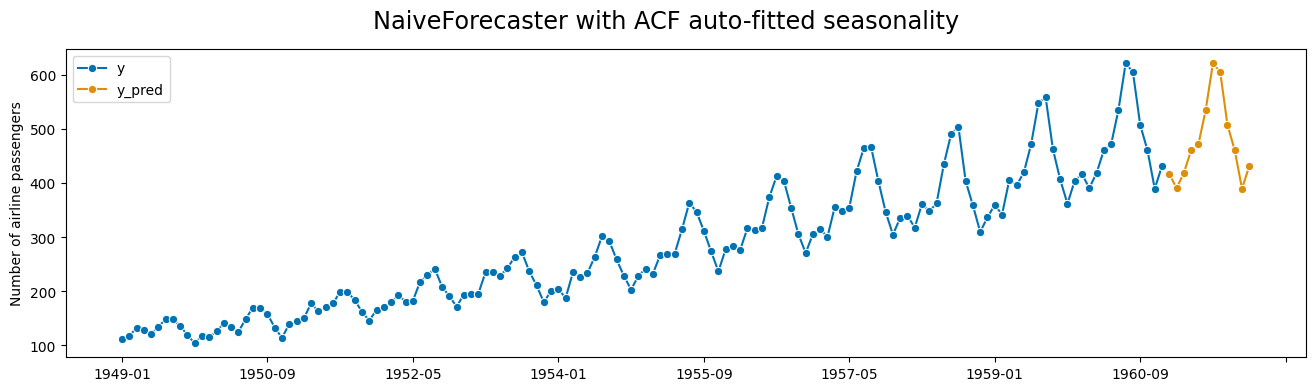

In [ ]:
y_pred = sp_auto.predict()

title = f"NaiveForecaster with ACF auto-fitted seasonality"
fig, ax = plot_series(
    y, y_pred, labels=["y", "y_pred"], title=title
)

also useful: conditional transformer `TransformIf`

* e.g., "test for seasonality, and deseasonalize, but only if there is seasonality"
* stationarity tester `StationarityADF` (Dickey-Fuller) - combine with `Differencer` via `TransformIf`

### 3.5.2 Tuning using grid or random search

Grid/parameter tuning has same syntax as in `sklearn`:

* `get_params` strings and `dict` to set parameter grid/range
* `cv` splitter to define evaluation modus

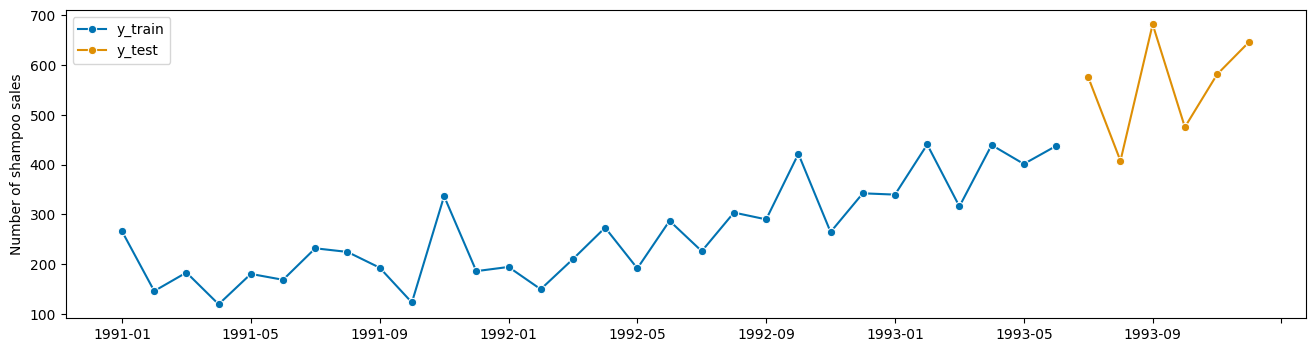

In [ ]:
from sktime.datasets import load_shampoo_sales
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split

y = load_shampoo_sales()
y_train, y_test = temporal_train_test_split(y=y, test_size=6)

plot_series(y_train, y_test, labels=["y_train", "y_test"]);

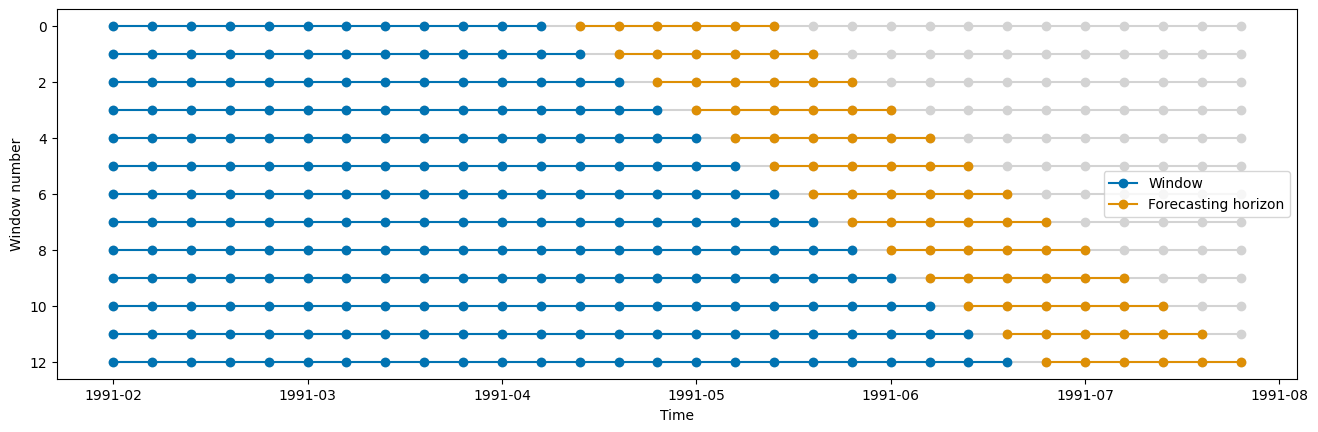

In [ ]:
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.utils.plotting import plot_windows

cv = ExpandingWindowSplitter(fh=[1,2,3,4,5,6], initial_window=12, step_length=1)
plot_windows(cv=cv, y=y_train)

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import MeanSquaredError

forecaster = ExponentialSmoothing()
param_grid = {
    "sp": [4, 6, 12],
    "seasonal": ["add", "mul"],
    "trend": ["add", "mul"],
    "damped_trend": [True, False],
}
gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    scoring=MeanSquaredError(square_root=True),
)

In [ ]:
gscv.fit(y_train)
fh = [1, 2, 3, 4, 5, 6]
y_pred = gscv.predict(fh=fh)

Fitting 13 folds for each of 24 candidates, totalling 312 fits


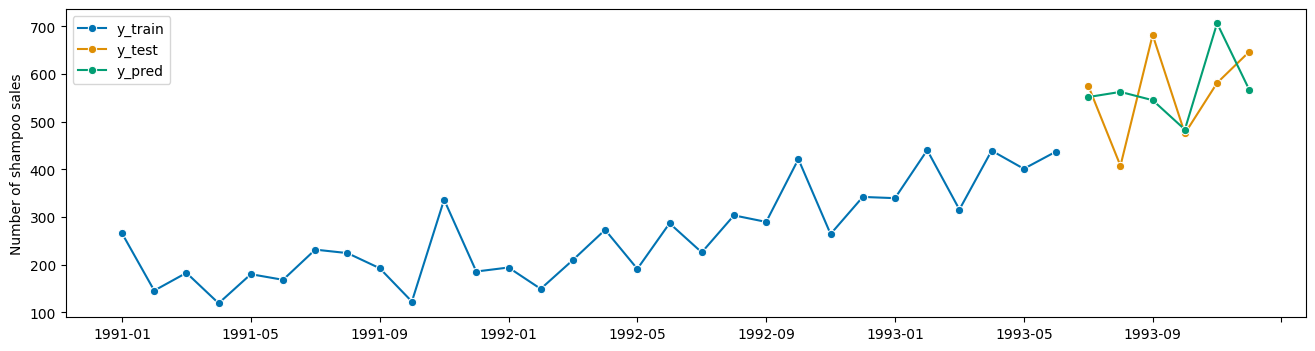

In [ ]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

In [ ]:
gscv.best_params_

{'damped_trend': True, 'seasonal': 'add', 'sp': 12, 'trend': 'mul'}

In [ ]:
# all fitted parameters also accessible via get_fitted_params
# this can be used in parameter plugin etc
gscv.get_fitted_params()["best_params"]

{'damped_trend': True, 'seasonal': 'add', 'sp': 12, 'trend': 'mul'}

In [ ]:
gscv.best_forecaster_

ExponentialSmoothing(damped_trend=True, seasonal='add', sp=12, trend='mul')

for pipelines and composites, parameter names are `[componentname]__[paramname]`:

In [ ]:
from sklearn.preprocessing import PowerTransformer, RobustScaler, MinMaxScaler
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.detrend import Deseasonalizer, Detrender

forecaster = TransformedTargetForecaster(
    steps=[
        ("detrender", Detrender()),
        ("deseasonalizer", Deseasonalizer()),
        ("minmax", TabularToSeriesAdaptor(MinMaxScaler((1, 10)))),
        ("power", TabularToSeriesAdaptor(PowerTransformer())),
        ("scaler", TabularToSeriesAdaptor(RobustScaler())),
        ("forecaster", ExponentialSmoothing()),
    ]
)

# using dunder notation to access inner objects/params as in sklearn
param_grid = {
    # deseasonalizer
    "deseasonalizer__model": ["multiplicative", "additive"],
    # power
    "power__transformer__method": ["yeo-johnson", "box-cox"],
    "power__transformer__standardize": [True, False],
    # forecaster
    "forecaster__sp": [4, 6, 12],
    "forecaster__seasonal": ["add", "mul"],
    "forecaster__trend": ["add", "mul"],
    "forecaster__damped_trend": [True, False],
}

gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    scoring=MeanSquaredError(square_root=True),  # set custom scoring function
)
gscv.fit(y_train)
y_pred = gscv.predict(fh=fh)

Fitting 13 folds for each of 192 candidates, totalling 2496 fits


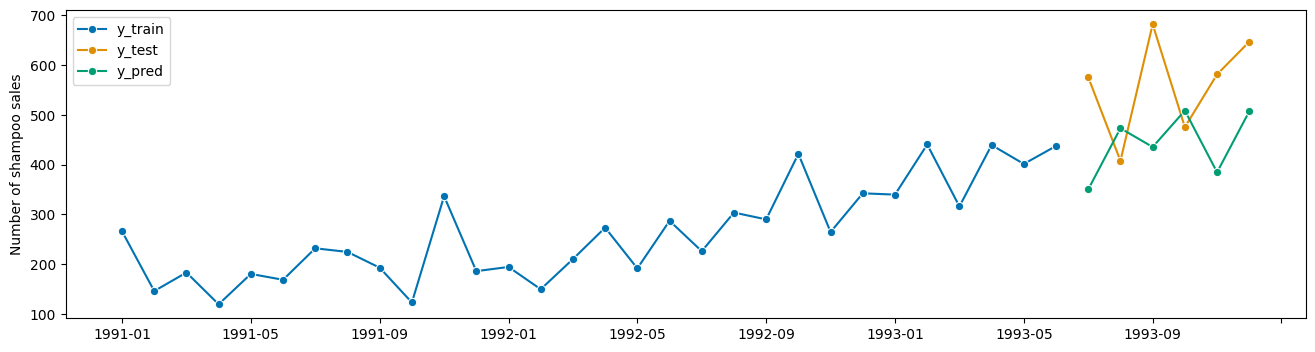

In [ ]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

In [ ]:
gscv.best_params_

{'deseasonalizer__model': 'additive',
 'forecaster__damped_trend': False,
 'forecaster__seasonal': 'add',
 'forecaster__sp': 4,
 'forecaster__trend': 'add',
 'power__transformer__method': 'yeo-johnson',
 'power__transformer__standardize': True}

In [ ]:
gscv.best_forecaster_

TransformedTargetForecaster(steps=[('detrender', Detrender()),
                                   ('deseasonalizer', Deseasonalizer()),
                                   ('minmax',
                                    TabularToSeriesAdaptor(transformer=MinMaxScaler(feature_range=(1, 10)))),
                                   ('power',
                                    TabularToSeriesAdaptor(transformer=PowerTransformer())),
                                   ('scaler',
                                    TabularToSeriesAdaptor(transformer=RobustScaler())),
                                   ('forecaster',
                                    ExponentialSmoothing(seasonal='add', sp=4,
                                                         trend='add'))])

In [ ]:
gscv.cv_results_.head()

,mean_test_MeanSquaredError,mean_fit_time,mean_pred_time,params,rank_test_MeanSquaredError
0,NaN,NaN,NaN,"{'deseasonalizer__model': 'multiplicative', 'f...",NaN
1,NaN,NaN,NaN,"{'deseasonalizer__model': 'multiplicative', 'f...",NaN
2,NaN,NaN,NaN,"{'deseasonalizer__model': 'multiplicative', 'f...",NaN
3,NaN,NaN,NaN,"{'deseasonalizer__model': 'multiplicative', 'f...",NaN
4,NaN,NaN,NaN,"{'deseasonalizer__model': 'multiplicative', 'f...",NaN


when using dunders - and in general - paramater names can be inspected using `get_params`

In [ ]:
forecaster = \
    Detrender() \
    * Deseasonalizer() \
    * MinMaxScaler((1, 10)) \
    * PowerTransformer() \
    * RobustScaler() \
    * ExponentialSmoothing()

In [ ]:
forecaster.get_params()

### AutoML -> next notebook :-)

## 3.6 Summary<a class="anchor" id="chapter5"></a>

* transformers are data processing steps with unified interface - `fit`, `transform`, and optional `inverse_transform`

* used as pipeline components for any learning task, forecasting, classification

* different types by input/output - time series, primitives, pairs of time series, panels/hierarchical.

* find transformers by tags such as `scitype:transform-output` and `scitype:instancewise` using `all_estimators`

* rich composition syntax - `*` for pipe, `+` for featureunion, `[in, out]` for variable subset, `|` for multiplex/switch

* `sktime` provides easy-to-use extension templates for transformers, build your own, plug and play

## 3.7 Appendix - cheat sheets and extension guie

### dunders glossary

| Type | Dunder | Meaning | `sktime` class |
| --- | --- | --- | --- |
| compose | `*` | chaining/pipeline - also works with other estimator types | type dependent |
| compose | `**` | chaining to secondary input of another estimator | type dependent |
| compose | `+` | feature union | `FeatureUnion` |
| interface | `~` | invert | `InvertTransform` |
| structural | `¦` | multiplexing ("switch") | type dependent |
| structural | `-` | optional passthrough ("on/off") | `OptionalPassthrough` |

### selected useful transformers, compositors, adapters

* delay fitting to `transform` via `sktime.transformations.compose.FitInTransform`
* any `pandas` method via `sktime.transformations.compose.adapt.PandasTransformAdaptor`
* date/time features via `sktime.transformations.series.date.DateTimeFeatures`
* lags via `transformations.series.lag.Lag`
* differences, first and n-th, via `transformations.series.difference.Differencer`
* scaled logit via `transformations.series.scaledlogit.ScaledLogitTransform`

### Extension guide - implementing your own transformer<a class="anchor" id="chapter4"></a>

`sktime` is meant to be easily extensible, for direct contribution to `sktime` as well as for local/private extension with custom methods.

To extend `sktime` with a new local or contributed transformer, a good workflow to follow is:

1. read through the [transformer extension template](https://github.com/alan-turing-institute/sktime/blob/main/extension_templates/transformer.py) - this is a `python` file with `todo` blocks that mark the places in which changes need to be added.
2. optionally, if you are planning any major surgeries to the interface: look at the [base class architecture](https://github.com/alan-turing-institute/sktime/blob/main/sktime/transformations/base.py) - note that "ordinary" extension (e.g., new algorithm) should be easily doable without this.
3. copy the transformer extension template to a local folder in your own repository (local/private extension), or to a suitable location in your clone of the `sktime` or affiliated repository (if contributed extension), inside `sktime.transformations`; rename the file and update the file docstring appropriately.
4. address the "todo" parts. Usually, this means: changing the name of the class, setting the tag values, specifying hyper-parameters, filling in `__init__`, `_fit`, `_transform`, and optional methods such as `_inverse_transform` or `_update` (for details see the extension template). You can add private methods as long as they do not override the default public interface. For more details, see the extension template.
5. to test your estimator manually: import your estimator and run it in the worfklows in Section 2.2; then use it in the compositors in Section 2.3.
6. to test your estimator automatically: call `sktime.tests.test_all_estimators.check_estimator` on your estimator. You can call this on a class or object instance. Ensure you have specified test parameters in the `get_test_params` method, according to the extension template.

In case of direct contribution to `sktime` or one of its affiliated packages, additionally:
* add yourself as an author to the code, and to the `CODEOWNERS` for the new estimator file(s).
* create a pull request that contains only the new estimators (and their inheritance tree, if it's not just one class), as well as the automated tests as described above.
* in the pull request, describe the estimator and optimally provide a publication or other technical reference for the strategy it implements.
* before making the pull request, ensure that you have all necessary permissions to contribute the code to a permissive license (BSD-3) open source project.

---

### Credits: notebook 3 - transformers

notebook creation: fkiraly, benheid

transformer pipelines & compositors: fkiraly, mloning, miraep8\
forecaster pipelines: fkiraly, aiwalter\
transformer base interface: mloning, fkiraly\
dunder interface: fkiraly, miraep8

Based on design ideas: sklearn, magrittr, mlr, mlj